In [49]:
import os, gc
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

np.random.seed(42)

DATA_DIR = "mallorn-challenge/"

train_log = pd.read_csv(f"{DATA_DIR}/train_log.csv")
test_log  = pd.read_csv(f"{DATA_DIR}/test_log.csv")

print("Cell 1 OK — Data Loaded.")


Cell 1 OK — Data Loaded.


In [50]:
def process_flux(df):
    eps = 1e-6
    flux_err_safe = df['Flux_err'].replace(0, np.nan)
    denom = np.power(flux_err_safe, 2) + eps
    flux_ratio_sq = np.power(df['Flux'], 2) / denom
    df_flux = pd.DataFrame({
        'flux_ratio_sq': flux_ratio_sq,
        'flux_by_flux_ratio_sq': df['Flux'] * flux_ratio_sq
    }, index=df.index)
    return pd.concat([df, df_flux], axis=1)

In [ ]:
from semver import process


def build_features_from_lightcurves(df):
    df = df.sort_values(["object_id", "Filter", "Time (MJD)"])

    df["w"] = 1.0 / (df["Flux_err"]**2 + 1e-9)
    df["flux_w"] = df["Flux"] * df["w"]
    df = process_flux(df)
    df["Flux_Real"]= df["Flux"]  * (10 ** ((df["EBV"].astype(float)+1e-9) * 3.1 / 2.5))  # apply_de_extinction(df)
    aggs = {
        "Flux": ["min","max","mean","median","std"],
        "Flux_Real": ['max', 'mean', 'min'],
        "Flux_err": ["mean"],
        "Time (MJD)": ["min","max","count"],
        "w": ["sum"],
        "flux_w": ["sum"],
        'flux_ratio_sq': ['max', 'mean', 'min', 'std'],
        'flux_by_flux_ratio_sq': ['max', 'mean', 'min', 'std']
    }

    agg = df.groupby(["object_id","Filter"]).agg(aggs)
    agg.columns = [f"{a}_{b}" for a,b in agg.columns]
    agg = agg.reset_index()

    agg["flux_amp"] = agg["Flux_max"] - agg["Flux_min"]
    agg["flux_rel_amp"] = agg["flux_amp"]/(agg["Flux_mean"]+1e-9)
    agg["time_span"] = agg["Time (MJD)_max"] - agg["Time (MJD)_min"]
    agg["flux_w_mean"] = agg["flux_w_sum"]/(agg["w_sum"]+1e-9)
    agg["slope"] = (agg["Flux_max"] - agg["Flux_min"]) / (agg["Time (MJD)_max"] - agg["Time (MJD)_min"] + 1e-9)
    agg["asymmetry"] = (agg["Flux_mean"] - agg["Flux_median"]) / (agg["Flux_std"] + 1e-9)
    agg["peak_sharpness"] = (agg["Flux_max"] - agg["Flux_mean"]) / (agg["Flux_std"] + 1e-9)
    
    if 'Flux_Real_max_u' in agg.columns and 'Flux_Real_max_g' in agg.columns:
        agg['color_u_g'] = agg['Flux_Real_max_u'] - agg['Flux_Real_max_g']
    else:
        agg['color_u_g'] = np.nan
    agg.drop(columns=["flux_w_sum","w_sum"], inplace=True)

    agg["has_filter"] = 1
    filt = agg.pivot(index="object_id", columns="Filter", values="has_filter").fillna(0)
    # pivot là sao? là chuyển cột thành hàng hay ngược lại
    # khác với với ca
    
    filt.columns = [f"has_{c}" for c in filt.columns]

    numeric_cols = [c for c in agg.columns if c not in ["object_id","Filter","has_filter"]]
    wide = agg.pivot(index="object_id", columns="Filter", values=numeric_cols)
    wide.columns = [f"{c[0]}_{c[1]}" for c in wide.columns]
    wide = wide.reset_index().fillna(0)

    return wide.merge(filt.reset_index(), on="object_id", how="left")


In [ ]:
from scipy.optimize import curve_fit

# Time-series features using Bazin fit and simple rise/decay heuristics

def bazin_func(time, A, B, t0, t_fall, t_rise):
    arg_fall = np.clip(-(time - t0) / t_fall, -20, 20)
    arg_rise = np.clip(-(time - t0) / t_rise, -20, 20)
    return A * (np.exp(arg_fall) / (1 + np.exp(arg_rise))) + B


def extract_timeseries_features(group):
    # Expect columns: Flux, Flux_err, Time (MJD)
    if group.empty:
        return pd.Series({
            'rise_time_raw': 0.0,
            'decay_time_raw': 0.0,
            'bazin_tau_rise': -1.0,
            'bazin_tau_fall': -1.0,
            'bazin_chisq': -1.0
        })

    flux = group['Flux'].values
    mjd = group['Time (MJD)'].values
    flux_err = group['Flux_err'].values

    idx_max = int(np.argmax(flux)) if len(flux) else 0
    t_peak = mjd[idx_max]
    f_peak = flux[idx_max]

    mask_detect = flux > 3 * flux_err
    if np.sum(mask_detect) >= 2:
        t_detect = mjd[mask_detect]
        t_min_detect = np.min(t_detect)
        t_max_detect = np.max(t_detect)
        rise_time = t_peak - t_min_detect
        decay_time = t_max_detect - t_peak
    else:
        rise_time = decay_time = 0.0

    p0 = [f_peak, np.min(flux), t_peak, 50.0, 10.0]

    try:
        popt, _ = curve_fit(
            bazin_func, mjd, flux, p0=p0, sigma=flux_err, maxfev=2000, bounds=([-np.inf, -np.inf, -np.inf, 1e-3, 1e-3], np.inf)
        )
        A_fit, B_fit, t0_fit, t_fall_fit, t_rise_fit = popt
        residuals = flux - bazin_func(mjd, *popt)
        chisq = np.sum((residuals / (flux_err + 1e-9)) ** 2)
    except Exception:
        t_fall_fit, t_rise_fit, chisq = -1.0, -1.0, -1.0

    return pd.Series({
        'rise_time_raw': rise_time,
        'decay_time_raw': decay_time,
        'bazin_tau_rise': t_rise_fit,
        'bazin_tau_fall': t_fall_fit,
        'bazin_chisq': chisq
    })

# Usage example (per object_id and filter):
# ts_feats = df.groupby(['object_id', 'Filter']).apply(extract_timeseries_features).reset_index()


In [ ]:
def load_splits(split_ids, mode="train"):
    all_feats = []
    for i in split_ids:
        fname = f"{DATA_DIR}/split_{i:02d}/{mode}_full_lightcurves.csv"
        if os.path.exists(fname):
            df = pd.read_csv(fname)
            feats = build_features_from_lightcurves(df)
            all_feats.append(feats)
            del df
            gc.collect()
    full = pd.concat(all_feats, ignore_index=True)
    return full.groupby("object_id",as_index=False).mean()

print("Loading TRAIN splits...")
train_feats = load_splits(range(1,21), mode="train")

train = train_feats.merge(
    train_log[["object_id","Z","Z_err","EBV","target"]],
    on="object_id", how="left"
).fillna(0)

for c in train.columns:
    if "flux_w_mean" in c:
        train[c+"_x_Z"] = train[c]*train["Z"]

feature_cols = [c for c in train.columns if c not in ["object_id","target"]]
X = train[feature_cols].values
y = train["target"].values

print("Train shape:", train.shape)


Loading TRAIN splits...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21040\1524873429.py:100: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  complex_stats = grouped.apply(advanced_stats)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21040\1524873429.py:149: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  colors['bolometric_lum'] = df.groupby('object_id', group_keys=False).apply(integrate_bolometric)
C:\Users\ADMIN\AppData\Local\Temp\ipy

In [ ]:
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_preds = np.zeros(X.shape[0])

models_lgb = []
models_xgb = []
models_cat = []

pos = (y==1).sum()
neg = (y==0).sum()
scale_pos_weight = neg/(pos+1)

params_lgb = {
    "objective":"binary",
    "metric":"binary_logloss",
    "learning_rate":0.03,
    "num_leaves":96,
    "feature_fraction":0.7,
    "bagging_fraction":0.7,
    "bagging_freq":1,
    "scale_pos_weight":scale_pos_weight,
    "verbosity":-1,
}

params_xgb = {
    "max_depth":7,
    "eta":0.03,
    "subsample":0.7,
    "colsample_bytree":0.7,
    "objective":"binary:logistic",
    "eval_metric":"logloss",
    "scale_pos_weight":scale_pos_weight,
    "tree_method":"hist",
}

print("Start 3-model Ensemble Training...")

for fold,(tr,va) in enumerate(skf.split(X,y)):
    print(f"\n=== FOLD {fold+1}/{N_FOLDS} ===")

    Xtr, ytr = X[tr], y[tr]
    Xva, yva = X[va], y[va]

    # LightGBM
    dtr_lgb = lgb.Dataset(Xtr,label=ytr)
    #dtr_lgb là gì? là 
    dva_lgb = lgb.Dataset(Xva,label=yva)
    m_lgb = lgb.train(
        params_lgb, dtr_lgb, num_boost_round=1000,
        valid_sets=[dtr_lgb,dva_lgb],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )
    models_lgb.append(m_lgb)
    pred_lgb = m_lgb.predict(Xva)

    # XGBoost
    dtr_xgb = xgb.DMatrix(Xtr,label=ytr)
    dva_xgb = xgb.DMatrix(Xva,label=yva)
    m_xgb = xgb.train(
        params_xgb, dtr_xgb, num_boost_round=1200,
        evals=[(dva_xgb,"eval")],
        early_stopping_rounds=80,
        verbose_eval=False
    )
    models_xgb.append(m_xgb)
    pred_xgb = m_xgb.predict(dva_xgb)

    # CatBoost
    m_cat = CatBoostClassifier(
        depth=8,
        learning_rate=0.03,
        iterations=1500,
        loss_function="Logloss",
        eval_metric="Logloss",
        random_seed=42,
        verbose=False
    )
    m_cat.fit(Xtr, ytr, eval_set=(Xva,yva))
    models_cat.append(m_cat)
    pred_cat = m_cat.predict_proba(Xva)[:,1]

    # Ensemble → OOF
    oof_preds[va] = (pred_lgb + pred_xgb + pred_cat) / 3


Start 3-model Ensemble Training...

=== FOLD 1/5 ===
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.0257814	valid_1's binary_logloss: 0.130337


KeyboardInterrupt: 

In [ ]:
best_thr = 0
best_f1 = 0

ths = np.linspace(0.05,0.40,200)
for t in ths:
    f1 = f1_score(y, (oof_preds>=t).astype(int))
    if f1>best_f1:
        best_f1 = f1
        best_thr = t

print("Best OOF threshold =", best_thr)
print("Best OOF F1 =", best_f1)


Best OOF threshold = 0.1484924623115578
Best OOF F1 = 0.41711229946524064


In [ ]:
print("Loading TEST splits...")
test_feats = load_splits(range(1,21), mode="test")

test = test_feats.merge(
    test_log[["object_id","Z","Z_err","EBV"]],
    on="object_id", how="left"
).fillna(0)

for c in test.columns:
    if "flux_w_mean" in c:
        test[c+"_x_Z"] = test[c]*test["Z"]

X_test = test[feature_cols].values
dtest  = xgb.DMatrix(X_test)

sub_preds = np.zeros(X_test.shape[0])

for i in range(N_FOLDS):
    p_lgb = models_lgb[i].predict(X_test)
    p_xgb = models_xgb[i].predict(dtest)
    p_cat = models_cat[i].predict_proba(X_test)[:,1]
    sub_preds += (p_lgb + p_xgb + p_cat)/3

sub_preds /= N_FOLDS

print("Test prediction OK.")


Loading TEST splits...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21040\1031295008.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  complex_stats = grouped.apply(advanced_stats)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21040\1031295008.py:152: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  colors['bolometric_lum'] = df.groupby('object_id').apply(integrate_bolometric)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21040\10312

Test prediction OK.


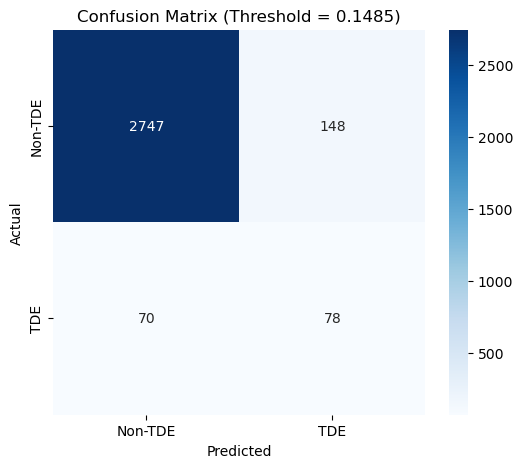

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21040\3120826585.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature",


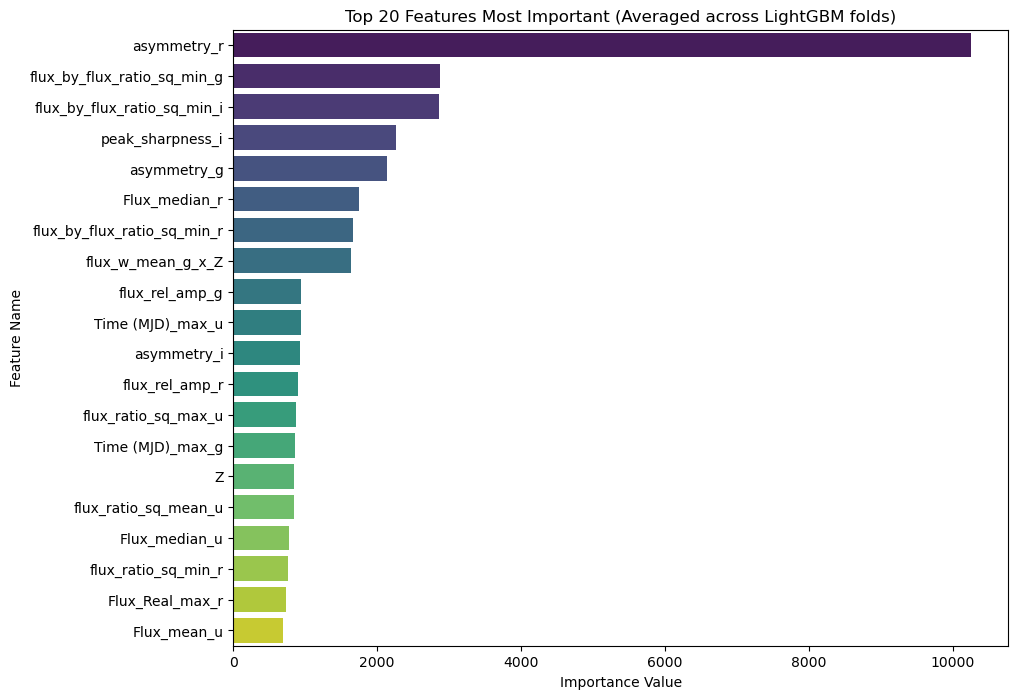

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix, classification_report

# Guard: ensure required variables exist
required_vars = ['oof_preds', 'best_thr', 'y']
missing = [v for v in required_vars if v not in globals()]
if missing:
    print(f"⚠️ Missing variables: {missing}. Run the training cells (definitions of oof_preds/best_thr/y) before this cell.")
else:
    # --- PART 1: CONFUSION MATRIX ---
    final_preds = (oof_preds >= best_thr).astype(int)
    cm = confusion_matrix(y, final_preds)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-TDE', 'TDE'], yticklabels=['Non-TDE', 'TDE'])
    plt.title(f'Confusion Matrix (Threshold = {best_thr:.4f})')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # --- PART 2: FEATURE IMPORTANCE (LightGBM models) ---
    def lgb_importances(models_lgb, feature_names):
        imp_list = []
        for m in models_lgb:
            try:
                feats = list(m.feature_name())
                imps = m.feature_importance(importance_type="gain")
            except AttributeError:
                feats = list(getattr(m, "feature_name_", feature_names or []))
                imps = m.feature_importances_
            if feature_names is not None and len(feats) == len(feature_names):
                feats = feature_names
            imp_list.append(pd.DataFrame({"Feature": feats, "Importance": imps}))
        if len(imp_list) == 0:
            return None
        return (pd.concat(imp_list, ignore_index=True)
                  .groupby("Feature", as_index=False)["Importance"].mean())

    lgb_imp = lgb_importances(models_lgb, feature_cols if 'feature_cols' in globals() else None)
    if lgb_imp is not None and len(lgb_imp) > 0:
        plt.figure(figsize=(10, 8))
        sns.barplot(x="Importance", y="Feature",
                    data=lgb_imp.sort_values(by="Importance", ascending=False).head(20),
                    palette="viridis")
        plt.title('Top 20 Features Most Important (Averaged across LightGBM folds)')
        plt.xlabel('Importance Value')
        plt.ylabel('Feature Name')
        plt.show()
    else:
        print("⚠️ No LightGBM models available to plot feature importance.")


In [ ]:
threshold_list = [best_thr, 
                  best_thr-0.01,
                  best_thr+0.01,
                  best_thr-0.02,
                  best_thr+0.02]

print("Use thresholds:", threshold_list)

for idx, thr in enumerate(threshold_list,1):
    pred = (sub_preds >= thr).astype(int)

    sub_df = pd.DataFrame({
        "object_id": test["object_id"],
        "prediction": pred
    })

    fname = f"submission_FE32_thr{idx}_{thr:.3f}.csv"
    sub_df.to_csv(fname,index=False)

    print(f"Saved {fname} | positives = {pred.sum()}")


Use thresholds: [0.1484924623115578, 0.1384924623115578, 0.1584924623115578, 0.1284924623115578, 0.1684924623115578]
Saved submission_FE32_thr1_0.148.csv | positives = 526
Saved submission_FE32_thr2_0.138.csv | positives = 557
Saved submission_FE32_thr3_0.158.csv | positives = 489
Saved submission_FE32_thr4_0.128.csv | positives = 603
Saved submission_FE32_thr5_0.168.csv | positives = 463
